Import packages

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

Pick file

In [2]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.head()

,timestamp,message,author,has_emoji
0,2017-05-12 17:43:00,12-05-2017 17:43 - Je bent toegevoegd\n,glittering-penguin,False
1,2022-09-16 09:26:00,Wachten op dit bericht\n,eye-catching-wolf,False
2,2022-09-16 07:31:00,Wachten op dit bericht\n,spattered-duck,False
3,2022-09-16 07:41:00,16-09-2022 07:41 - Schjöpschen: Wachten op dit...,riotous-dingo,False
4,2022-09-16 08:21:00,Wachten op dit bericht\n,translucent-dog,False


Length of message

In [5]:
# Calculate the word count for each message
df['word_count'] = df['message'].str.split().str.len()
df.head() 

,timestamp,message,author,has_emoji,word_count
0,2017-05-12 17:43:00,12-05-2017 17:43 - Je bent toegevoegd\n,glittering-penguin,False,6
1,2022-09-16 09:26:00,Wachten op dit bericht\n,eye-catching-wolf,False,4
2,2022-09-16 07:31:00,Wachten op dit bericht\n,spattered-duck,False,4
3,2022-09-16 07:41:00,16-09-2022 07:41 - Schjöpschen: Wachten op dit...,riotous-dingo,False,8
4,2022-09-16 08:21:00,Wachten op dit bericht\n,translucent-dog,False,4


/tmp/ipykernel_7140/953488329.py:3: RuntimeWarning: divide by zero encountered in log
  df["log_len"] = df["word_count"].apply(lambda x: np.log(x))


<Axes: xlabel='log_len', ylabel='Count'>

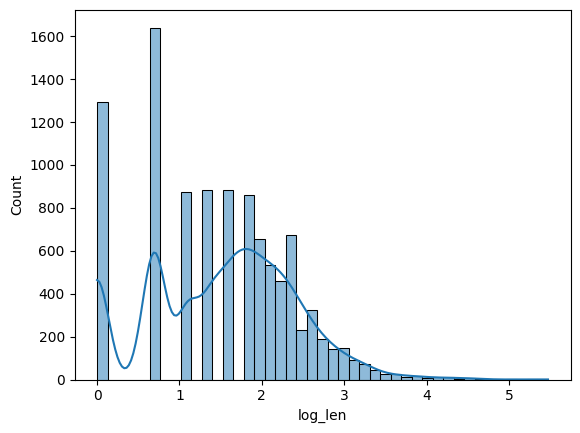

In [7]:
import numpy as np

df["log_len"] = df["word_count"].apply(lambda x: np.log(x))
sns.histplot(df, x="log_len", kde=True)